In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal, interpolate
import pandas as pd

import h5py

# Set font size for plots
matplotlib.rcParams['font.size'] = 12

# Create time vector
n = 50000
t = np.linspace(-250, 250, n)
cm = 1/2.54  # cm to inches
# Load variables from .mat file
vars = loadmat("Waveforms/nondegenerate.mat")

with h5py.File("Waveforms/AllTraces.mat", 'r') as f:
    # List all groups
    print("Keys: %s" % f.keys())
    # Get the data
    vars2 = {key: np.array(f[key]) for key in f.keys()}

# Reverse and flatten the time and field arrays
meas1Time = np.flip(vars["nondegen_20230415_10ms_longgateshortsig_time"].flatten())
meas1Field = np.flip(vars["nondegen_20230415_10ms_longgateshortsig_total"].flatten())



Keys: <KeysViewHDF5 ['Analytical20230329', 'Analytical20230403', 'Analytical20230415', 'AnalyticalTime', 'Meas20230329', 'Meas20230403', 'Meas20230415', 'TDSE15Vnm20230329', 'TDSE15Vnm20230403', 'TDSE15Vnm20230415', 'TDSETime20230403', 'TDSETime20230415', 'TDSEtime20230329']>


In [2]:

# Accessing fields from the HDF5 file
analytical_time = vars2['AnalyticalTime'].flatten()
analytical_20230415 = vars2['Analytical20230415'].flatten()

# interpolate the measured field to the analytical time

# Create interpolation function with extrapolation value 0

interpAnalytical = interpolate.interp1d(
    analytical_time,
    analytical_20230415.real,
    kind='linear',
    fill_value=0,
    bounds_error=False
)

In [3]:
# Make a hamming filter to smooth the data
hamming = np.hamming(n)


In [4]:
def parse_complex(s):
    s = s.replace('im', 'j').replace(' ', '')  # Ersetze 'im' durch 'j' und entferne Leerzeichen
    return complex(s)

# CSV-Datei einlesen
pump = pd.read_csv("FilteredWaveformDeg.csv")

# Konvertiere die 'field'-Spalte in komplexe Zahlen
pump['field'] = pump['field'].apply(parse_complex)

# Extrahiere die Zeit- und Feldspalten
pump_time = pump['time'].values
pump_values = pump['field'].values



In [5]:


# Compute Hilbert transform and normalize
meas1Cmplx = signal.hilbert(meas1Field)
meas1Cmplx = meas1Cmplx / np.max(np.abs(meas1Cmplx))

# Create interpolation function with extrapolation value 0
interpMeas = interpolate.interp1d(
    meas1Time,
    meas1Cmplx.real,
    kind='linear',
    fill_value=0,
    bounds_error=False
)

# Read CSV files with complex values
signal_data = np.genfromtxt("FilteredWaveformSCG0415.csv", delimiter=',', dtype=complex)


signal_time = signal_data[:, 0].real
signal_values = signal_data[:, 1]

# Create interpolation functions for pump and signal
interpPump = interpolate.interp1d(
    pump_time,
    pump_values.real,
    kind='linear',
    fill_value=0,
    bounds_error=False
)

interpSignal = interpolate.interp1d(
    np.flip(signal_time),
    np.flip(signal_values.real),
    kind='linear',
    fill_value=0,
    bounds_error=False
)


# load csv SampledWaveform15Vnm0415.csv
tdseResults = np.genfromtxt("SampledWaveform15Vnm0415.csv", delimiter=',')

tdseTime = (tdseResults[:, 0])
tdseField = (tdseResults[:, 1])

# Create interpolation function for TDSE results
interpTDSE = interpolate.interp1d(
    tdseTime,
    tdseField,
    kind='linear',
    fill_value=0,
    bounds_error=False
)


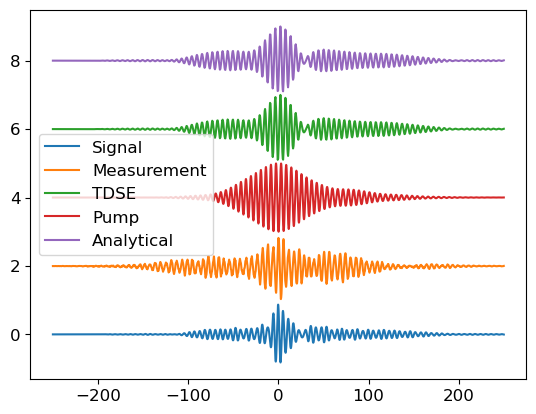

In [6]:

# Plot the interpolated signals
plt.figure()
plt.plot(t, interpSignal(t)*hamming, label='Signal')
plt.plot(t, interpMeas(t)*hamming + 2, label='Measurement')
plt.plot(t, np.flip(interpTDSE(t)*hamming + 6), label='TDSE')
plt.plot(t, interpPump(t)*hamming + 4, label='Pump')
plt.plot(t, interpAnalytical(t)*hamming + 8, label='Analytical')
plt.legend()
plt.show()



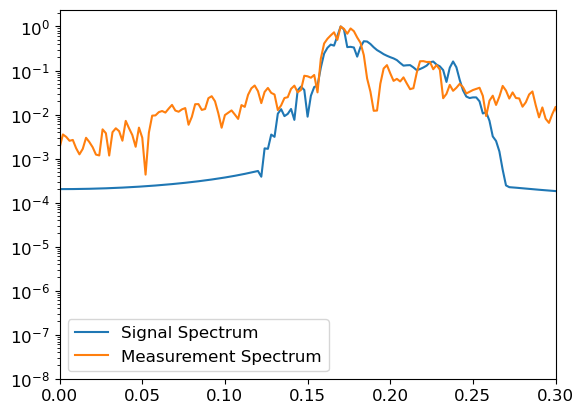

In [7]:

# Convert all signals to complex signals using Hilbert transform
measC = signal.hilbert(interpMeas(t))
measC = measC / np.max(np.abs(measC))
measC = measC - np.mean(measC)

pumpC = signal.hilbert(interpPump(t))
pumpC = pumpC / np.max(np.abs(pumpC))

signalC = signal.hilbert(interpSignal(t))
signalC = signalC / np.max(np.abs(signalC))

tdseC = signal.hilbert(interpTDSE(t))
tdseC = tdseC / np.max(np.abs(tdseC))

analyticalC = signal.hilbert(interpAnalytical(t))
analyticalC = analyticalC / np.max(np.abs(analyticalC))

# Create spectra using FFT
pumpSpectrum = np.fft.fftshift(np.fft.fft(pumpC.real*hamming))
pumpSpectrum = pumpSpectrum / np.max(np.abs(pumpSpectrum))

signalSpectrum = np.fft.fftshift(np.fft.fft(signalC.real*hamming))
signalSpectrum = signalSpectrum / np.max(np.abs(signalSpectrum))

measSpectrum = np.fft.fftshift(np.fft.fft(measC.real*hamming))
measSpectrum = measSpectrum / np.max(np.abs(measSpectrum))

tdseSpectrum = np.fft.fftshift(np.fft.fft(tdseC.real*hamming))
tdseSpectrum = tdseSpectrum / np.max(np.abs(tdseSpectrum))

analyticalSpectrum = np.fft.fftshift(np.fft.fft(analyticalC.real*hamming))
analyticalSpectrum = analyticalSpectrum / np.max(np.abs(analyticalSpectrum))

# Create frequency vector
dt = np.abs(t[1] - t[0])
f = np.fft.fftshift(np.fft.fftfreq(len(t), d=dt))

# Plot the spectra (assuming deconvolution result is signalSpectrum for demonstration)
plt.figure()
plt.semilogy(f, np.abs(signalSpectrum), label='Signal Spectrum')
plt.semilogy(f, np.abs(measSpectrum), label='Measurement Spectrum')
plt.xlim(0, 0.3)
plt.legend()
plt.show()

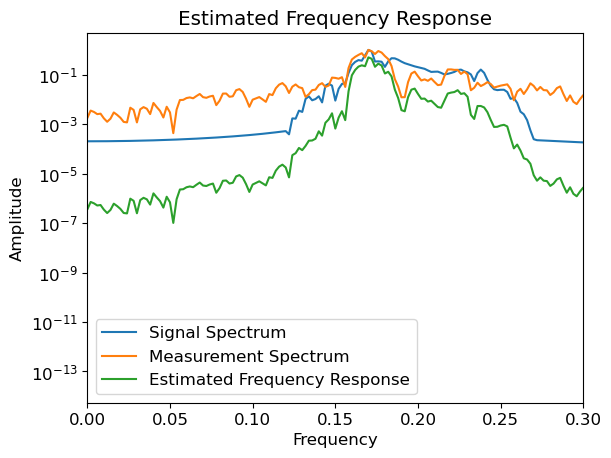

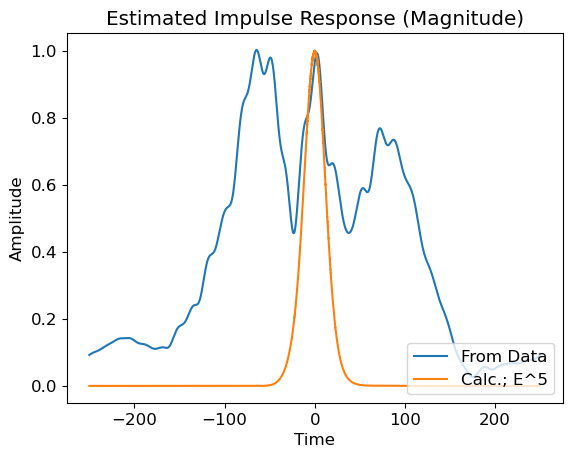

In [8]:
# Perform Wiener deconvolution to estimate the frequency response H(f)
def wiener_deconvolution(Y, X, K):
    X_conj = np.conj(X)
    H = (Y * X_conj) / (np.abs(X)**2 + K)
    return H

# Estimate the noise power K (you may need to adjust this based on your data)
K = 1  # Regularization parameter to mitigate noise amplification

# Compute the estimated frequency response H(f)
H_estimated = wiener_deconvolution(measSpectrum, signalSpectrum, K)
H_estimatedSim = wiener_deconvolution(tdseSpectrum, signalSpectrum, K)
H_estimatedAnalytical = wiener_deconvolution(analyticalSpectrum, signalSpectrum, K)


# Compute the impulse response h(t) by taking the inverse FFT of H(f)
h_time = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(H_estimated)))
h_time = np.real(h_time)  # Take the real part

h_timeSim = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(H_estimatedSim)))
h_timeSim = np.real(h_timeSim)  # Take the real part

h_timeAnalytical = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(H_estimatedAnalytical)))
h_timeAnalytical = np.real(h_timeAnalytical)  # Take the real part

# Normalize the impulse response
h_time = h_time / np.max(np.abs(h_time))
h_timeSim = h_timeSim / np.max(np.abs(h_timeSim))
h_timeAnalytical = h_timeAnalytical / np.max(np.abs(h_timeAnalytical))


plt.figure()
plt.semilogy(f, np.abs(signalSpectrum), label='Signal Spectrum')
plt.semilogy(f, np.abs(measSpectrum), label='Measurement Spectrum')
plt.plot(f, np.abs(H_estimated), label='Estimated Frequency Response')
plt.title('Estimated Frequency Response')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.legend()
plt.xlim(0, 0.3)
plt.show()
# # Plot the impulse response

#convert h_time to complex response
h_time = signal.hilbert(h_time)
h_timeSim = signal.hilbert(h_timeSim)
h_timeAnalytical = signal.hilbert(h_timeAnalytical)

plt.figure()
plt.plot(t, np.abs(h_time), label='From Data')
plt.plot(t,np.abs(pumpC)**6, label='Calc.; E^5')
plt.title('Estimated Impulse Response (Magnitude)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(loc='lower right')
plt.show()

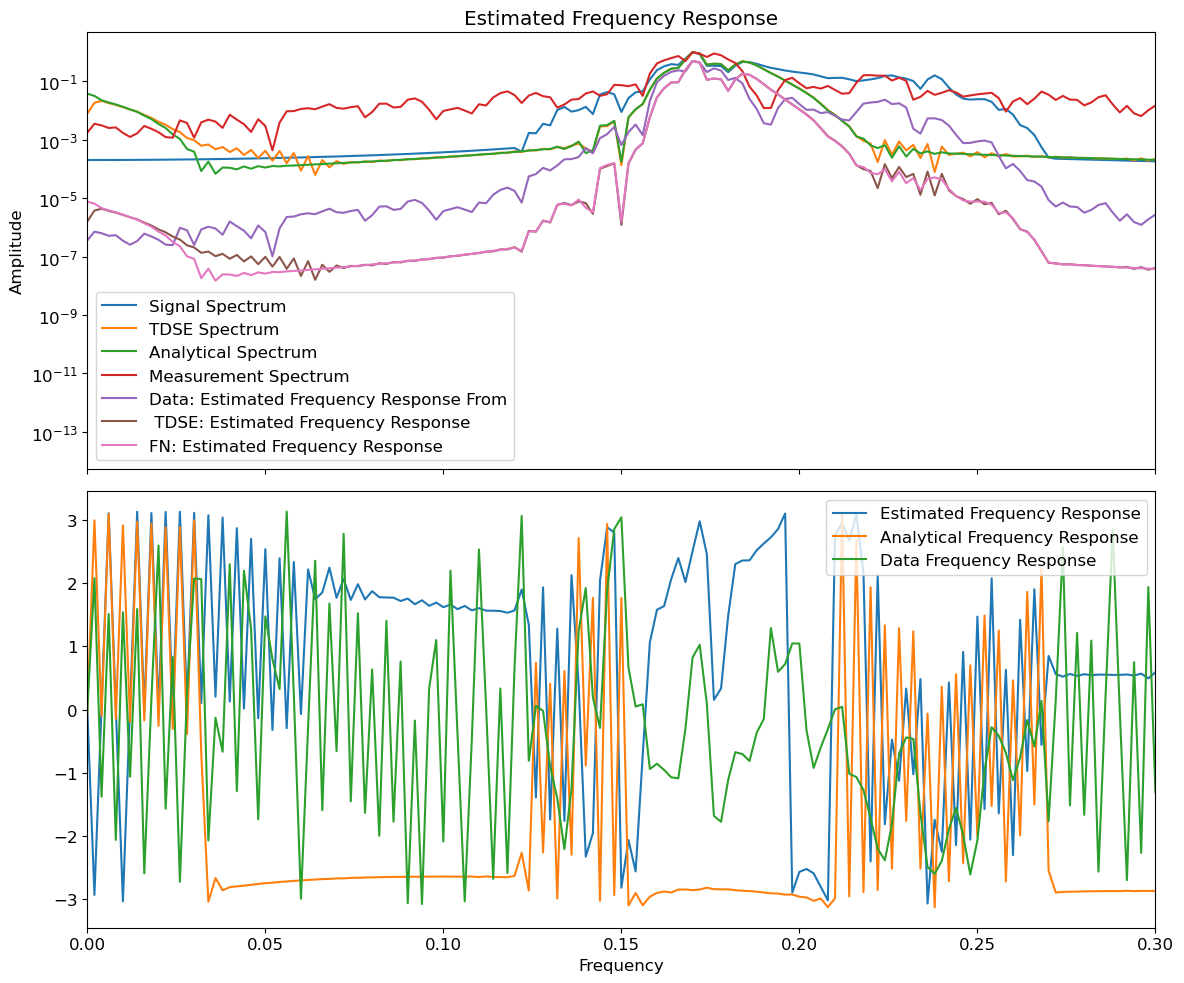

In [18]:

fig, [ax, ax2] = plt.subplots(2, 1, figsize=(12, 10),sharex=True)

ax.semilogy(f, np.abs(signalSpectrum), label='Signal Spectrum')
ax.semilogy(f, np.abs(tdseSpectrum), label='TDSE Spectrum')
ax.semilogy(f, np.abs(analyticalSpectrum), label='Analytical Spectrum')
ax.semilogy(f, np.abs(measSpectrum), label='Measurement Spectrum')
ax.semilogy(f, np.abs(H_estimated), label='Data: Estimated Frequency Response From')
ax.semilogy(f, np.abs(H_estimatedSim), label=' TDSE: Estimated Frequency Response')
ax.semilogy(f, np.abs(H_estimatedAnalytical), label='FN: Estimated Frequency Response')
ax.set_title('Estimated Frequency Response')
ax.set_ylabel('Amplitude')
ax.legend()

ax2.plot(f, (np.angle(H_estimatedSim)), label='Estimated Frequency Response' )
ax2.plot(f, (np.angle(H_estimatedAnalytical)), label='Analytical Frequency Response')
ax2.plot(f, (np.angle(H_estimated)), label='Data Frequency Response')
ax2.set_xlabel('Frequency')
ax2.set_xlim(0, 0.3)
ax2.legend()

plt.tight_layout()
plt.show()

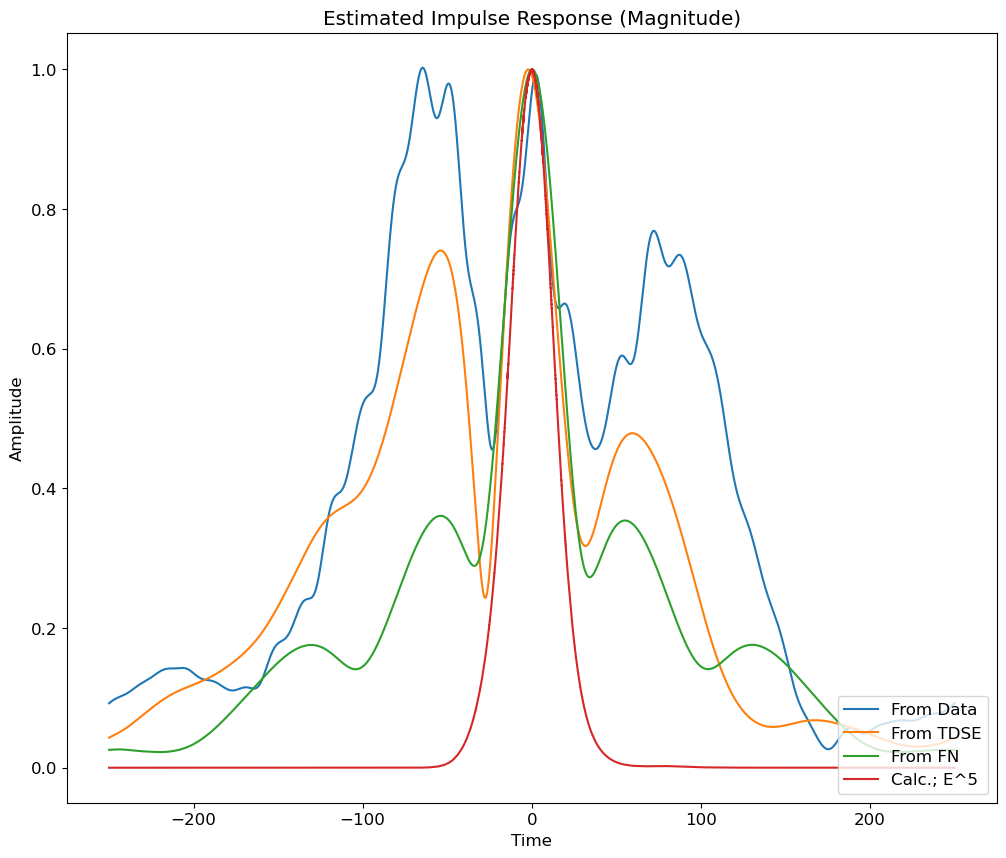

In [20]:
# Plotting the time domain

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.plot(t, np.abs(h_time), label='From Data')
ax.plot(t, np.abs(h_timeSim), label='From TDSE')
ax.plot(t, np.abs(h_timeAnalytical), label='From FN')
ax.plot(t, np.abs(pumpC)**5, label='Calc.; E^5')
ax.set_title('Estimated Impulse Response (Magnitude)')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.legend(loc='lower right')
plt.show()